In [4]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

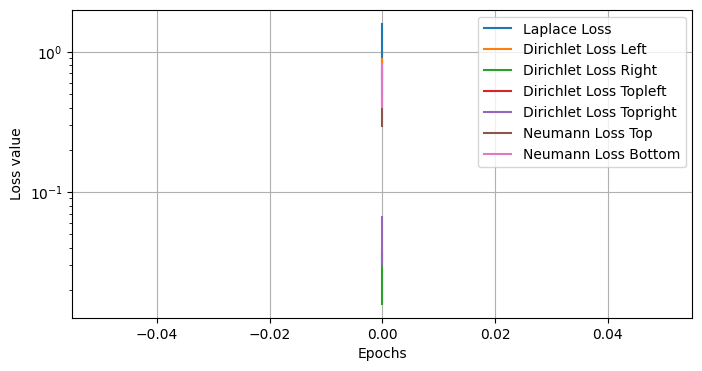

Epoch: 0 Loss weights: [11.       10.999999 10.999994 11.       10.999997 10.999999 10.999999]
Normalized losses: []


KeyboardInterrupt: 

In [46]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]  # Change Tanh to GeLU
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # Change Tanh to GeLU
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points

def plot_losses(epochs, losses_dict):
    plt.figure(figsize=(8, 4))
    
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epochs, loss_values, label=loss_name)
    
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()

def closure():
    global loss_weights  # Make loss_weights modifiable in this function
    optimizer.zero_grad()  # Clear previous gradients

    # Compute individual loss terms
    loss_laplace = laplace_residual(model, train_points)
    loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
    loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
    loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
    loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)
    loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
    loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')
    
    # Compute mean loss for normalization
    # mean_loss = (loss_laplace + loss_d_l + loss_d_r + loss_d_tl + loss_d_tr + loss_n_t + loss_n_b) / 7
    # normalized_losses = torch.tensor(
    #     [loss_laplace, loss_d_l, loss_d_r, loss_d_tl, loss_d_tr, loss_n_t, loss_n_b],
    #     dtype=torch.float
    # ) / mean_loss



    # Combine losses using the updated weights
    loss = (
        loss_weights[0] * loss_laplace +
        loss_weights[1] * loss_d_l +
        loss_weights[2] * loss_d_r +
        loss_weights[3] * loss_d_tl +
        loss_weights[4] * loss_d_tr +
        loss_weights[5] * loss_n_t +
        loss_weights[6] * loss_n_b
    )

    # Backpropagate the total loss to update the model
    # loss.backward()
    
    # Record losses and weights
    laplace_losses.append(loss_laplace.item())
    dirichlet_losses_left.append(loss_d_l.item())
    dirichlet_losses_right.append(loss_d_r.item())
    dirichlet_losses_topleft.append(loss_d_tl.item())
    dirichlet_losses_topright.append(loss_d_tr.item())
    neumann_losses_top.append(loss_n_t.item())
    neumann_losses_bottom.append(loss_n_b.item())
    epochs_recorded.append(epoch)
    loss_weights_recorded.append(loss_weights.detach().clone())

    # Update loss weights with damping and clipping
    # if epoch%1==0:
    # with torch.no_grad():
    #     loss_weights = loss_weights + (normalized_losses-1)*100
    #     loss_weights = torch.clamp(loss_weights, min=1, max=10000)

    return loss


def closure_loss_weights():
    loss_weights_optimizer.zero_grad()  # Clear gradients for loss_weights
    # Reverse the gradient for maximization by negating the loss
    loss = -closure()  # Negate the loss to maximize
    loss.backward()
    return loss
#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

left_dirichlet,target_left_dirichlet = create_boundary_points('vertical', left, 0, top, 1000, 1)  # Left boundary
boundary_points_dirichlet_left=torch.cat([left_dirichlet],dim=0).requires_grad_(True)  # Concatenate Dirichlet boundary points
target_points_dirichlet_left=torch.cat([target_left_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

right_dirichlet, target_right_dirichlet = create_boundary_points('vertical', right, 0, top, 1000, 0) # Right boundary
boundary_points_dirichlet_right=torch.cat([right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary points
target_points_dirichlet_right=torch.cat([target_right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

topleft_dirichlet, target_topleft_dirichlet= create_boundary_points('horizontal', top, 0, 0.3*right, 5000, 1)
boundary_points_dirichlet_topleft=torch.cat([topleft_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topleft=torch.cat([target_topleft_dirichlet],dim=0).requires_grad_(True)

topright_dirichlet,target_topright_dirichlet = create_boundary_points('horizontal', top, 0.7*right, 1*right, 5000, 0)
boundary_points_dirichlet_topright=torch.cat([topright_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topright=torch.cat([target_topright_dirichlet],dim=0).requires_grad_(True)

top_neumann=create_boundary_points('horizontal', top, 0.3*right, 0.7*right, 1000)
boundary_points_neumann_top=torch.cat([top_neumann],dim=0).requires_grad_(True)

bottom_neumann=create_boundary_points('horizontal', bottom, 0, right, 1000)
boundary_points_neumann_bottom=torch.cat([bottom_neumann],dim=0).requires_grad_(True)


# Creating domain points
num_domain_points=10000
x_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses_left = []
dirichlet_losses_right = []
dirichlet_losses_topleft = []
dirichlet_losses_topright = []
neumann_losses_top = []
neumann_losses_bottom = []
epochs_recorded = []

loss_weights_recorded=[]
normalized_losses_recorded=[]


#Defining changeable parameters:
model=pinn(hidden_size=20, hidden_layers=8) # to be used for evaluating u at boundaries and inside the domain
# adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Using the Adam optimizer #amsgrad=True
# lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=40) #Using the Adam optimizer
lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b = 1,1,1,1,1,1,1

epochs=2300

# Add trainable weights for each loss term
loss_weights =(torch.tensor([lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b], 
                            dtype=torch.float, requires_grad=True))

# Combine model parameters and loss_weights into the optimizer
# Optimizer for the model parameters (minimization problem)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optimizer for the loss_weights (maximization problem)
loss_weights_optimizer = torch.optim.Adam([loss_weights], lr=10)  # Smaller learning rate for stability

# Combine model parameters and loss_weights for LBFGS
lbfgs_optimizer = torch.optim.LBFGS(
    list(model.parameters()) + [loss_weights], lr=0.1, max_iter=40
)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Use Xavier initialization
        nn.init.zeros_(m.bias)  # Initialize biases to zero

# Apply weight initialization
model.apply(initialize_weights)

#Training loop:
for epoch in range(epochs):
    optimizer = adam_optimizer if epoch < 1 else lbfgs_optimizer
   
    if isinstance(optimizer, torch.optim.LBFGS):
        # 1. Minimize loss with respect to model parameters
        def closure_model():
            optimizer.zero_grad()  # Clear gradients for model
            loss = closure()  # Calculate loss
            loss.backward()  # Retain the graph for reuse
            return loss

        lbfgs_optimizer.step(closure_model)

        # # 2. Maximize loss_weights
        def closure_loss_weights():
            loss_weights_optimizer.zero_grad()  # Clear gradients for loss_weights
            # Reverse the gradient for maximization by negating the loss
            loss = -closure()  # Negate the loss to maximize
            loss.backward()
            return loss

        # wight_closure=closure_loss_weights()
        loss_weights_optimizer.step(closure_loss_weights)

    else:
        # loss=closure()
        # optimizer.step() # Update
        # loss_weights_optimizer.step(closure_loss_weights)

        # 1. Minimize loss with respect to model parameters
        def closure_model():
            adam_optimizer.zero_grad()  # Clear gradients for model
            loss = closure()  # Calculate loss
            loss.backward()  # Retain the graph for reuse
            return loss

        adam_optimizer.step(closure_model)

        # # 2. Maximize loss_weights
        def closure_loss_weights():
            loss_weights_optimizer.zero_grad()  # Clear gradients for loss_weights
            # Reverse the gradient for maximization by negating the loss
            loss = -closure()  # Negate the loss to maximize
            loss.backward()
            return loss

        # wight_closure=closure_loss_weights()
        loss_weights_optimizer.step(closure_loss_weights)



    # Logging
    if optimizer == adam_optimizer and epoch % 500 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)
        print("Epoch:",epoch, "Loss weights:", loss_weights.detach().numpy())
        print(f"Normalized losses: {normalized_losses_recorded}")


    if optimizer == lbfgs_optimizer and epoch % 50 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)

        print("Epoch:",epoch, "Loss weights:", loss_weights.detach().numpy())


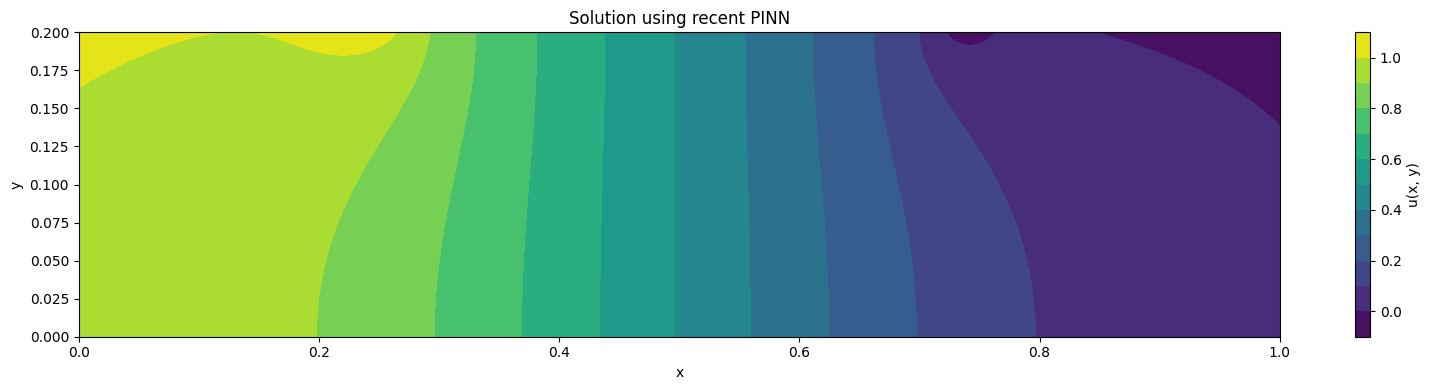

In [40]:
# Plot the results
num=100
x = torch.linspace(0, right, 600)
y=torch.linspace(0, top, 200)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# PINN solution
predicted_u = model(test_points).detach().numpy().reshape(600, 200) #detach, numpy are used to convert the tensor to numpy array, reshape to coordinates.

plt.figure(figsize=(16, 4))

# PINN solution plot
plt.contourf(X.numpy(), Y.numpy(), predicted_u, 10, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution using recent PINN")

plt.tight_layout()
plt.show()

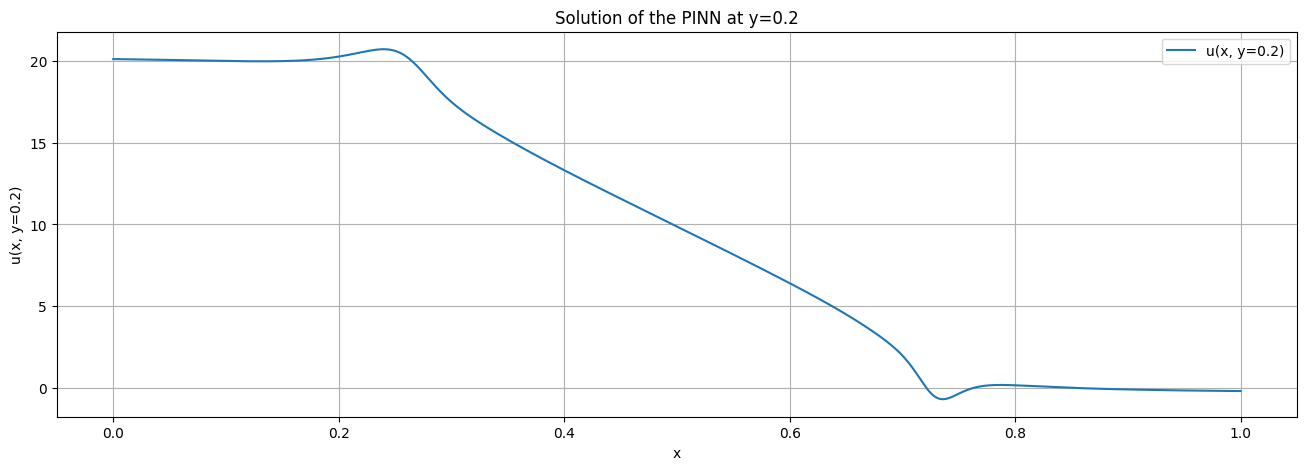

In [43]:
# Define the x values (0 to 1) and keep y fixed at 0.2
x = np.linspace(0, 1, 1000)  # 1000 points along x
y = np.full_like(x, 0.2)     # Keep y constant at 0.2

# Combine x and y into points for evaluation
points = torch.tensor(np.c_[x, y], dtype=torch.float32)

# Evaluate the model
solution = 20* model(points).detach().numpy()

# Plot the solution
plt.figure(figsize=(16, 5))
plt.plot(x, solution, label="u(x, y=0.2)")
plt.title("Solution of the PINN at y=0.2")
plt.xlabel("x")
plt.ylabel("u(x, y=0.2)")
plt.grid()
plt.legend()
plt.show()

In [42]:
# Assume `model` is your trained instance of the `pinn` class
model_path = "trained_pinn_model_dynweights.pth"
torch.save(model.state_dict(), model_path)
print(f"Model's state dictionary saved to {model_path}")

Model's state dictionary saved to trained_pinn_model_dynweights.pth


In [ ]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]  # Change Tanh to GeLU
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # Change Tanh to GeLU
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points

def plot_losses(epochs, losses_dict):
    plt.figure(figsize=(8, 4))
    
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epochs, loss_values, label=loss_name)
    
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()

#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

left_dirichlet,target_left_dirichlet = create_boundary_points('vertical', left, 0, top, 1000, 1)  # Left boundary
boundary_points_dirichlet_left=torch.cat([left_dirichlet],dim=0).requires_grad_(True)  # Concatenate Dirichlet boundary points
target_points_dirichlet_left=torch.cat([target_left_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

right_dirichlet, target_right_dirichlet = create_boundary_points('vertical', right, 0, top, 1000, 0) # Right boundary
boundary_points_dirichlet_right=torch.cat([right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary points
target_points_dirichlet_right=torch.cat([target_right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

topleft_dirichlet, target_topleft_dirichlet= create_boundary_points('horizontal', top, 0, 0.3*right, 5000, 1)
boundary_points_dirichlet_topleft=torch.cat([topleft_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topleft=torch.cat([target_topleft_dirichlet],dim=0).requires_grad_(True)

topright_dirichlet,target_topright_dirichlet = create_boundary_points('horizontal', top, 0.7*right, 1*right, 5000, 0)
boundary_points_dirichlet_topright=torch.cat([topright_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topright=torch.cat([target_topright_dirichlet],dim=0).requires_grad_(True)

top_neumann=create_boundary_points('horizontal', top, 0.3*right, 0.7*right, 2000)
boundary_points_neumann_top=torch.cat([top_neumann],dim=0).requires_grad_(True)

bottom_neumann=create_boundary_points('horizontal', bottom, 0, right, 2000)
boundary_points_neumann_bottom=torch.cat([bottom_neumann],dim=0).requires_grad_(True)


# Creating domain points
num_domain_points=10000
x_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses_left = []
dirichlet_losses_right = []
dirichlet_losses_topleft = []
dirichlet_losses_topright = []
neumann_losses_top = []
neumann_losses_bottom = []
epochs_recorded = []


#Defining changeable parameters:
model=pinn(hidden_size=40, hidden_layers=8) # to be used for evaluating u at boundaries and inside the domain
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Using the Adam optimizer #amsgrad=True
lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=40) #Using the Adam optimizer
lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b = 10,100,100,1000,1000,100,100

epochs=7501

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Use Xavier initialization
        nn.init.zeros_(m.bias)  # Initialize biases to zero

# Apply weight initialization
model.apply(initialize_weights)
#Training loop:
for epoch in range(epochs):
    optimizer = adam_optimizer if epoch < 6000 else lbfgs_optimizer
   
    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        loss_laplace=laplace_residual(model,train_points)

        loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
        loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
        loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
        loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)

        loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
        loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')

        # Add other boundary losses if needed
        loss = loss_d_l * y_d_l + loss_d_r * y_d_r + loss_d_tl * y_d_tl + loss_d_tr * y_d_tr + loss_n_t * y_n_t + loss_n_b * y_n_b + loss_laplace * lambda_laplace
   
        loss.backward()  # Compute gradients
        
        # Append losses to the lists
        laplace_losses.append(loss_laplace.item()) 
        dirichlet_losses_left.append(loss_d_l.item())
        dirichlet_losses_right.append(loss_d_r.item())
        dirichlet_losses_topleft.append(loss_d_tl.item())
        dirichlet_losses_topright.append(loss_d_tr.item())
        neumann_losses_top.append(loss_n_t.item())
        neumann_losses_bottom.append(loss_n_b.item())
        
        epochs_recorded.append(epoch) 


        return loss

    # Step with LBFGS, passing in the closure

    if isinstance(optimizer, torch.optim.LBFGS):
        optimizer.step(closure)
    else:
        optimizer.zero_grad() #Have to zero the gradients at the start of each epoch
        #losses
        loss_laplace=laplace_residual(model,train_points)

        loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
        loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
        loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
        loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)

        loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
        loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')

        loss = loss_d_l * y_d_l + loss_d_r * y_d_r + loss_d_tl * y_d_tl + loss_d_tr * y_d_tr + loss_n_t * y_n_t + loss_n_b * y_n_b + loss_laplace * lambda_laplace

        # Backward pass
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Clipping the gradients
        optimizer.step() # Update

        # Append losses to the lists
        laplace_losses.append(loss_laplace.item()) 
        dirichlet_losses_left.append(loss_d_l.item())
        dirichlet_losses_right.append(loss_d_r.item())
        dirichlet_losses_topleft.append(loss_d_tl.item())
        dirichlet_losses_topright.append(loss_d_tr.item())
        neumann_losses_top.append(loss_n_t.item())
        neumann_losses_bottom.append(loss_n_b.item())
        
        epochs_recorded.append(epoch) 

    # scheduler.step(loss)

    # Logging
    if optimizer == adam_optimizer and epoch % 2000 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)

        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet toppleft: {loss_d_tl.item():.3E}")
        # plot_losses(epochs_recorded, laplace_losses, loss_d_l, neumann_losses, total_losses)
    if optimizer == lbfgs_optimizer and epoch % 200 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)

        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet toppleft: {loss_d_tl.item():.3E}")
        # plot_losses(epochs_recorded, laplace_losses, loss_d_l, neumann_losses, total_losses)